<a href="https://colab.research.google.com/github/MGG-8010/mod10/blob/master/scRNAseqTutorialKallisto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing and analysis of single-cell RNA-seq with kallisto|bustools 

This notebook is based on the one available [here](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_getting_started.ipynb) using methods described in the following publications:
* Bray, N. L., Pimentel, H., Melsted, P. & Pachter, L. Near-optimal probabilistic RNA-seq quantification. Nat. Biotechnol. 34, 525–527 (2016).
* Melsted, P., Ntranos, V. & Pachter, L. The Barcode, UMI, Set format and BUStools. Bioinformatics (2019). doi:10.1093/bioinformatics/btz279
* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. BioRxiv (2019). doi:10.1101/673285
* Wolf, F. A., Angerer, P. & Theis, F. J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biol. 19, 15 (2018).

and using placenta single cell data available through arrayexpress [E-MTAB-6701](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6701/) from the following publication:
* Vento-Tormo R, Efremova M, Botting RA, Turco MY, Vento-Tormo M, Meyer KB, Park
JE, Stephenson E, Polański K, Goncalves A, Gardner L, Holmqvist S, Henriksson J, 
Zou A, Sharkey AM, Millar B, Innes B, Wood L, Wilbrey-Clark A, Payne RP, Ivarsson
MA, Lisgo S, Filby A, Rowitch DH, Bulmer JN, Wright GJ, Stubbington MJT, Haniffa 
M, Moffett A, Teichmann SA. Single-cell reconstruction of the early
maternal-fetal interface in humans. Nature. 2018 Nov;563(7731):347-353. doi:10.1038/s41586-018-0698-6. 

In [1]:
!date

Mon Dec  9 12:21:27 UTC 2019


In [0]:
# Trick the system into giving us more RAM
new_list = [1]*409600000000

## Install `kb` (includes kallisto and bustools)

Install `kb` for running the kallisto|bustools workflow

In [1]:
!time pip install kb-python==0.24.1


     |████████████████████████████████| 35.4MB 66.9MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47896 sha256=b9049ae8105266ac11b7db6d3949469621a4807897144b9444164db27947b0e1
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=27879 sha256=3c1c3c4f33e3bfb21d53384ae916cb7907d177b87f5fe549faa74dc82b9b2f5a
  Stored in directory: /root/.cache/pip/wheels/6c/fb/3d/5c43eb691bd92a3ddd0ebeb6e7e78ceaf3ae1cb8d54b89a7fb
Successfully built loompy numpy-groupies

real	0m11.179s
user	0m6.563s
sys	0m1.135s


### Run kb to download reference genome for kallisto

In [7]:
!kb ref --help 

usage: kb ref [-h] [--keep-tmp] [--verbose] -i INDEX -g T2G -f1 FASTA
              [-f2 FASTA] [-c1 T2C] [-c2 T2C] [-d {human,mouse,linnarsson}]
              [--lamanno] [--overwrite]
              fasta gtf

Build a kallisto index and transcript-to-gene mapping

positional arguments:
  fasta                 Genomic FASTA file
  gtf                   Reference GTF file

optional arguments:
  -h, --help            Show this help message and exit
  --keep-tmp            Do not delete the tmp directory
  --verbose             Print debugging information
  -d {human,mouse,linnarsson}
                        Download a pre-built kallisto index (along with all
                        necessary files) instead of building it locally
  --lamanno             Prepare files for RNA velocity based on La Manno et
                        al. 2018 logic
  --overwrite           Overwrite existing kallisto index

required arguments:
  -i INDEX              Path to the kallisto index to be constructed


In [2]:
!time kb ref -d human -i idx.idx -g t2g.txt -f1 ref.fa

[2019-12-09 12:22:25,093]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
[2019-12-09 12:24:04,801]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz

real	2m15.067s
user	0m38.351s
sys	0m12.282s


## Getting the fastq data

Here we will use E-MTAB-6701 as example. You can download it from the FTP site using wget, or attach it to a previously downloaded version to a google shared drive. Request access by cliking [here](https://drive.google.com/drive/u/4/folders/1F6CPNFnf07EBX9GnAZtAX-DxxmAANwfJ).

In [0]:
##!wget ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-6701/FCA7474064_S1_L001_R1_001.fastq.gz
##!wget ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-6701/FCA7474064_S1_L001_R2_001.fastq.gz


## Access fastq files in shared drive OpenData


In [3]:
## If you have a google account request access to this shared drive:
## https://drive.google.com/drive/u/4/folders/1F6CPNFnf07EBX9GnAZtAX-DxxmAANwfJ
## drive/Shared\ drives/OpenData/RVT_2019-08-31
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
!kb count --help

usage: kb count [-h] [--keep-tmp] [--verbose] -i INDEX -g T2G -x TECHNOLOGY
                [-o OUT] [-w WHITELIST] [-t THREADS] [-m MEMORY] [-c1 T2C]
                [-c2 T2C] [--overwrite] [--lamanno | --filter [{bustools}]]
                [--loom | --h5ad]
                fastqs [fastqs ...]

Generate count matrices from a set of single-cell FASTQ files. Run `kb --list`
to view single-cell technology information.

positional arguments:
  fastqs                FASTQ files

optional arguments:
  -h, --help            Show this help message and exit
  --keep-tmp            Do not delete the tmp directory
  --verbose             Print debugging information
  -o OUT                Path to output directory (default: current directory)
  -w WHITELIST          Path to file of whitelisted barcodes to correct to. If
                        not provided and bustools supports the technology, a
                        pre-packaged whitelist is used. If not, the bustools
                        

In [9]:
!time kb count -i idx.idx -g t2g.txt -x 10xv2 --h5ad -t 8 -m 16\
      drive/Shared\ drives/OpenData/RVT_2019-08-31/FCA7474068_S1_L001_R1_001.fastq.gz \
      drive/Shared\ drives/OpenData/RVT_2019-08-31/FCA7474068_S1_L001_R2_001.fastq.gz \
      -o FCA7474068


[2019-12-09 12:31:06,388]    INFO Generating BUS file from
[2019-12-09 12:31:06,388]    INFO         drive/Shared drives/OpenData/RVT_2019-08-31/FCA7474068_S1_L001_R1_001.fastq.gz
[2019-12-09 12:31:06,388]    INFO         drive/Shared drives/OpenData/RVT_2019-08-31/FCA7474068_S1_L001_R2_001.fastq.gz
[2019-12-09 12:56:51,563]    INFO Sorting BUS file FCA7474068/output.bus to tmp/output.s.bus
[2019-12-09 13:00:00,097]    INFO Whitelist not provided
[2019-12-09 13:00:00,097]    INFO Copying pre-packaged 10XV2 whitelist to FCA7474068
[2019-12-09 13:00:00,312]    INFO Inspecting BUS file tmp/output.s.bus
[2019-12-09 13:00:30,946]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist FCA7474068/10xv2_whitelist.txt
[2019-12-09 13:01:08,481]    INFO Sorting BUS file tmp/output.s.c.bus to FCA7474068/output.unfiltered.bus
[2019-12-09 13:03:16,067]    INFO Generating count matrix FCA7474068/counts_unfiltered/cells_x_genes from BUS file FCA7474068/output.unfiltere

In [0]:
## Creating a copy on the drive. 
##!cp -R ./FCA7474068 drive/Shared\ drives/OpenData/RVT_bus/

## Perform basic analysis with ScanPy 

*   Based on the Jupyter notebook from [kallistobus.tools/getting_started](https://www.kallistobus.tools/getting_started) 

### Install python packages

In [13]:
!pip install scanpy[louvain] 
!pip install MulticoreTSNE

  Using cached https://files.pythonhosted.org/packages/c9/df/e0957422a85e924501afbff2f9283e02d93cefcb04aa8319ade7af68d266/scanpy-1.4.4.post1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e9/69/f5e05f578585ed9935247be3788b374f90701296a70c8871bcd6d21edb00/matplotlib-3.0.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/53/34/22b6c2ded558976b5367be01b851ae679a0d1ba994de002d54afe84187b5/numba-0.46.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/0f/a0/4e7134f803737aa6eebb4e5250565ace0e2599659e22be7f7eba520ff017/python-igraph-0.7.1.post6.tar.gz
Processing /root/.cache/pip/wheels/f2/c3/d4/f7abaf064186d6214ef952bbb72fd6c5136d4b17dbeaeff481/louvain-0.6.1-cp36-cp36m-linux_x86_64.whl
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2216050 sha256=920e0126923be4e4ac969af384c8e8f9509d990bab080001608b9cbba8840527
  Stored in directory: /roo

  Using cached https://files.pythonhosted.org/packages/2d/e8/2afa896fa4eebfa1d0d0ba2673fddac45582ec0f06b2bdda88108ced5425/MulticoreTSNE-0.1.tar.gz
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68507 sha256=d02995deaa0760b1775aae400a16d462d0d104afc75a4195097f79dbd9294a24
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


### Import Packages

In [0]:
import scanpy as sc
from scipy import sparse, io
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

### Import result

In [0]:
folder = "FCA7474068/counts_unfiltered/"

The annotated dataframe has rows (obs) which are cell barcodes, columns (var) which are genes. The actual matrix `adata.X` is a sparse matrix.

In [0]:
adata = sc.read(folder + "adata.h5ad")

In [18]:
adata

AnnData object with n_obs × n_vars = 529202 × 60623 

### Make the knee plot

In [0]:
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


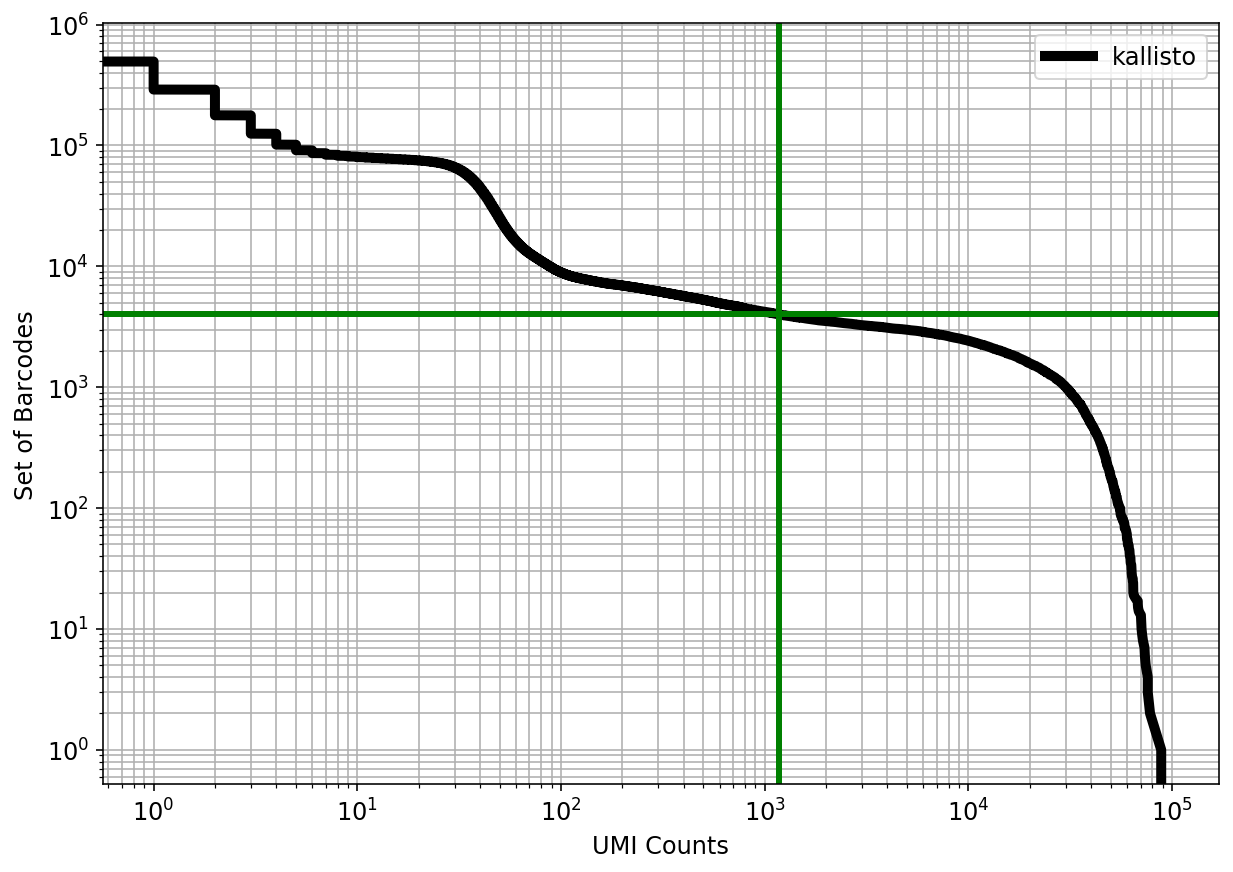

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))

expected_num_cells=4000

ax.loglog(knee, range(len(knee)), label="kallisto", linewidth=5, color="k")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="g")
ax.axhline(y=expected_num_cells, linewidth=3, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
ax.legend()
plt.show()

### Filter cells

In [0]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=knee[expected_num_cells])
sc.pp.filter_genes(adata, min_cells=0)

In [22]:
adata

AnnData object with n_obs × n_vars = 4002 × 60623 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

### Distribution of genes

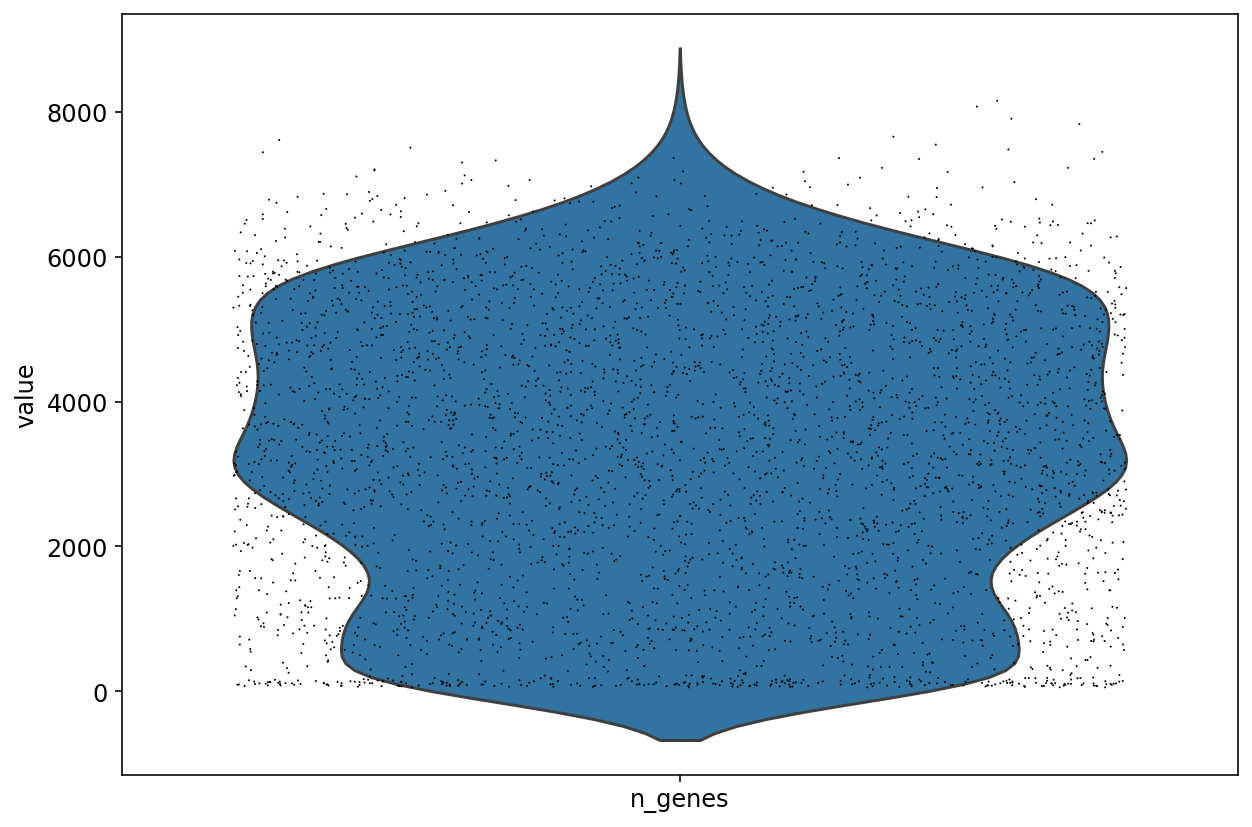

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_genes', jitter=0.4, ax=ax)

### Distribution of counts

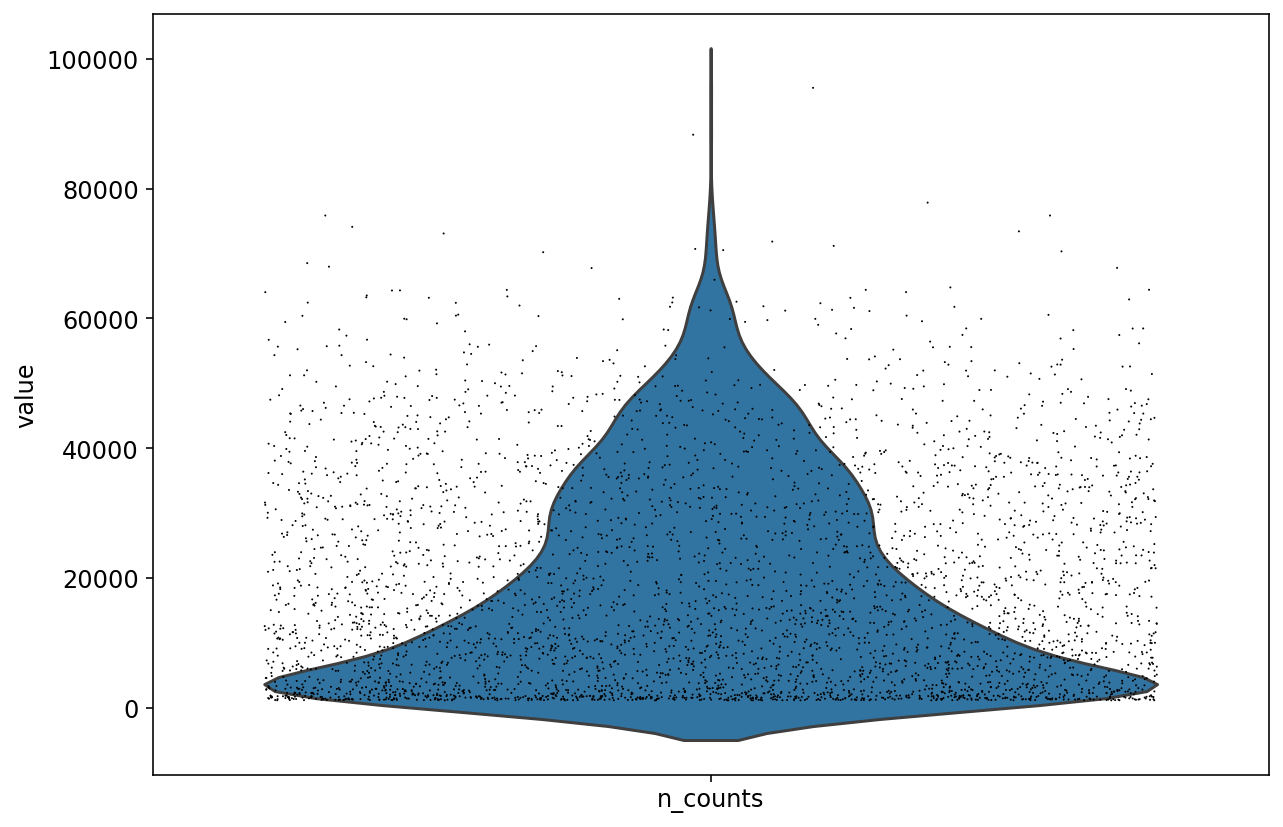

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_counts', jitter=0.4, ax=ax)

Normalize the counts in the matrix

In [0]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

apply $log(1+count)$ to all counts in your matrix

In [0]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [0]:
sc.pp.log1p(adata)

Filter adata for highly variable genes, and make `fadata` which only contains highly variable genes for further analysis.

### Highly variable genes

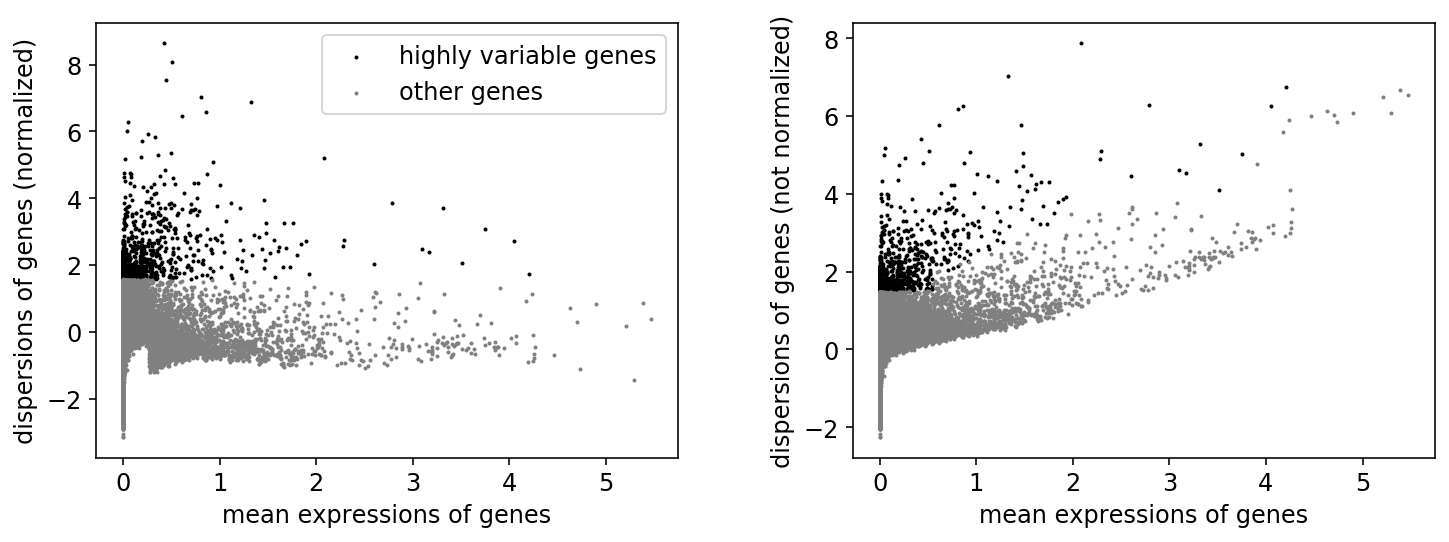

In [28]:
filter_result = sc.pp.highly_variable_genes(adata, min_disp=0.3,inplace=False, n_top_genes=1209)

sc.pl.highly_variable_genes(filter_result)

In [29]:
print("{:,} highly variable genes".format(sum(x[0] for x in filter_result)))

1,209 highly variable genes


### Cluster with Louvain and Plot PCA, UMAP, TSNE

In [30]:
%%time
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.louvain(adata)

CPU times: user 35.4 s, sys: 7.83 s, total: 43.2 s
Wall time: 16.7 s


In [31]:
%%time
sc.tl.tsne(adata, n_pcs=10)

CPU times: user 28.4 s, sys: 0 ns, total: 28.4 s
Wall time: 28.4 s


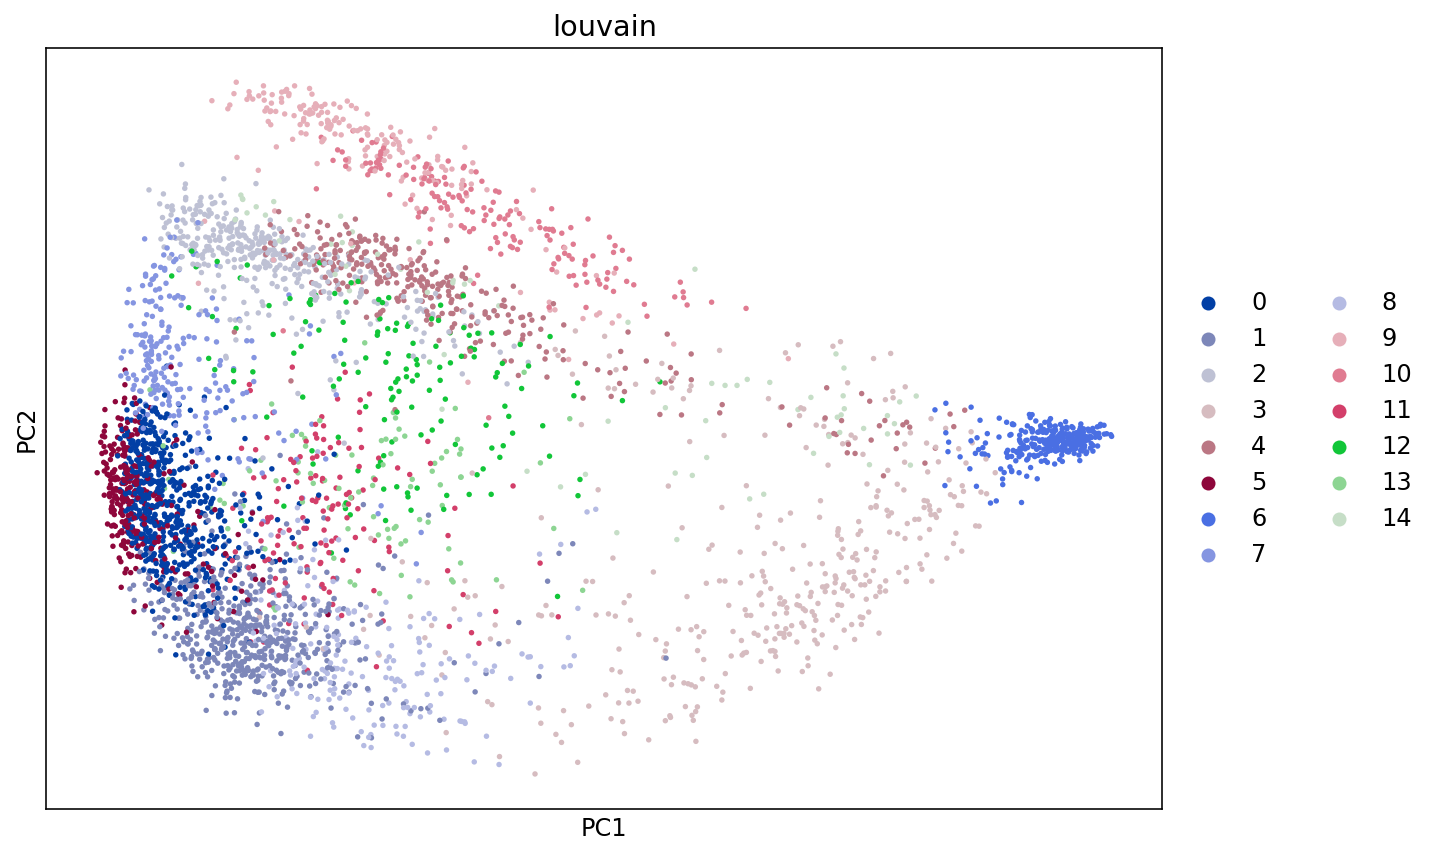

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color="louvain", ax=ax)

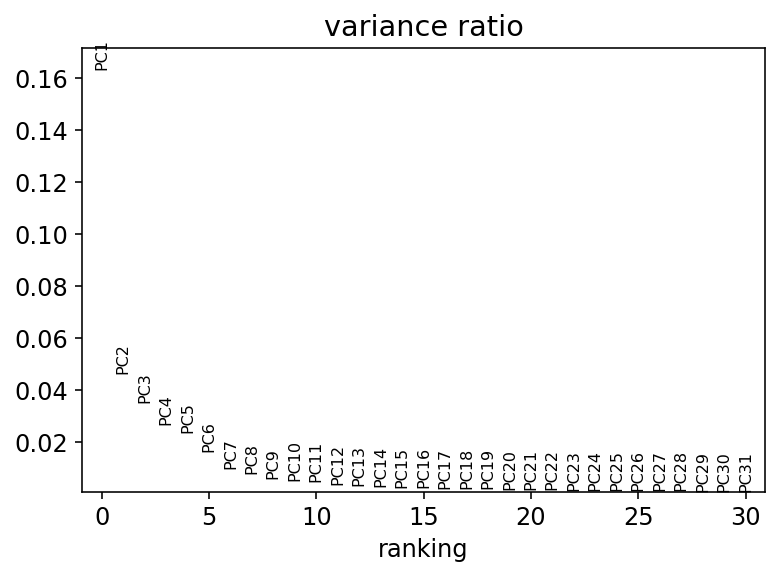

In [33]:
sc.pl.pca_variance_ratio(adata)

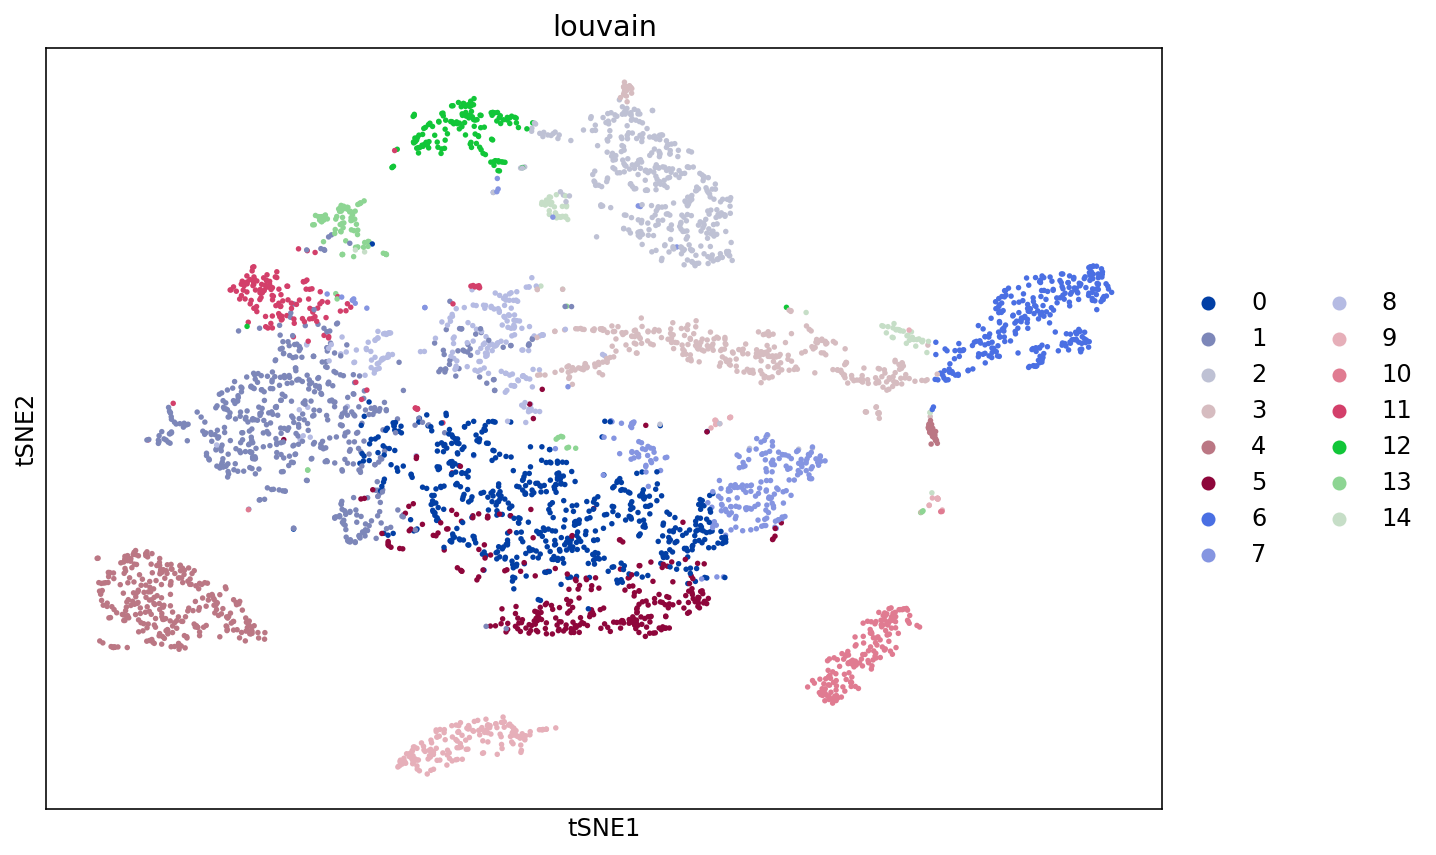

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color="louvain", ax=ax, save="getting_started_tsne.png")

In [0]:
!date

Mon Dec  9 13:21:53 UTC 2019


In [0]:
import umap

In [0]:
plane_mapper = umap.UMAP(random_state=42).fit(adata)

In [0]:
sc.tl.umap(adata)

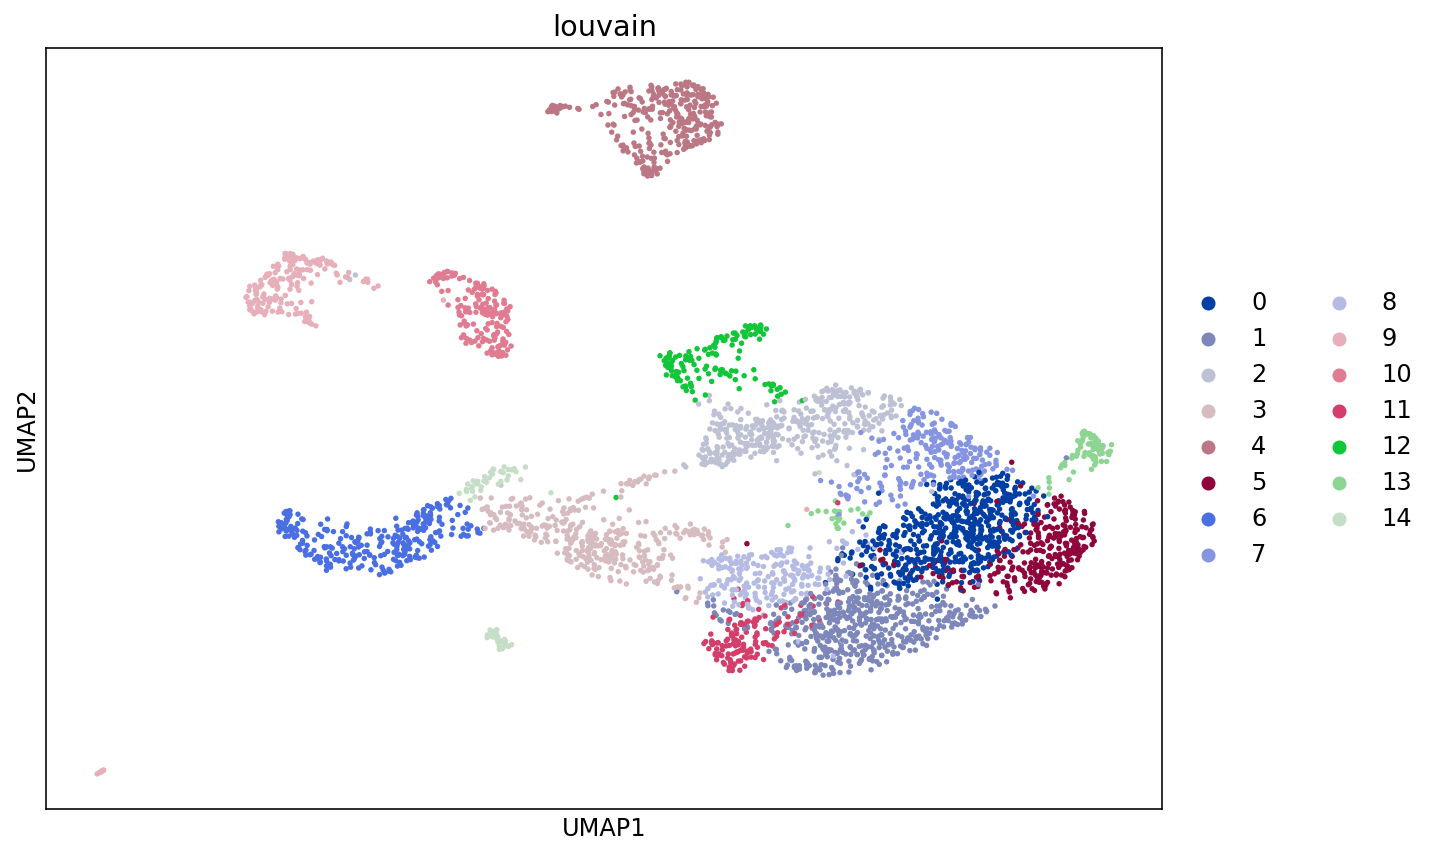

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color="louvain", ax=ax, save="getting_started_umap.png")